In [2]:
!pip install filetype


[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: C:\Users\tkame\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\tkame\AppData\Local\Temp\ipykernel_10936\2985001797.py:114: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(pairwise_distances(distance_matrix), method='average')  # Change method as needed


(23, 4)
24
Files processed:
0: ./data\BUILDING DATA WAREHOUSE.pptx
1: ./data\Completion Certificate.pdf
2: ./data\Completion Certificate.pdf.pptx
3: ./data\Completion Certificate.pptx
4: ./data\ctf task 1.docx
5: ./data\DOC-20230720-WA0006_230720_111516.pdf
6: ./data\DOC-20241109-WA0005..pdf
7: ./data\exercise3.c
8: ./data\Ex_10_2020239007.ipynb
9: ./data\GUIDEMARKSSHEET23.doc
10: ./data\InternAttendance_1[1].docx
11: ./data\INTRODUCTION TO DATA WAREHOUSING-1.pptx
12: ./data\Kameswaran-2020239007.pdf
13: ./data\Mapping datawarehouse multiprocessor architecture.ppt
14: ./data\NeurIPS-2019-foundations-of-comparison-based-hierarchical-clustering-Paper.pdf
15: ./data\NIFTY 50-16-10-2023-to-16-10-2024.csv
16: ./data\NLP-Unit-1,2-Question Bank.docx
17: ./data\Picture1.png
18: ./data\Picture2.png
19: ./data\Picture3.png
20: ./data\Screenshot 2022-08-04 185747.png
21: ./data\Screenshot 2023-08-20 163216.png
22: ./data\Sketch.png
23: ./data\template.pdf


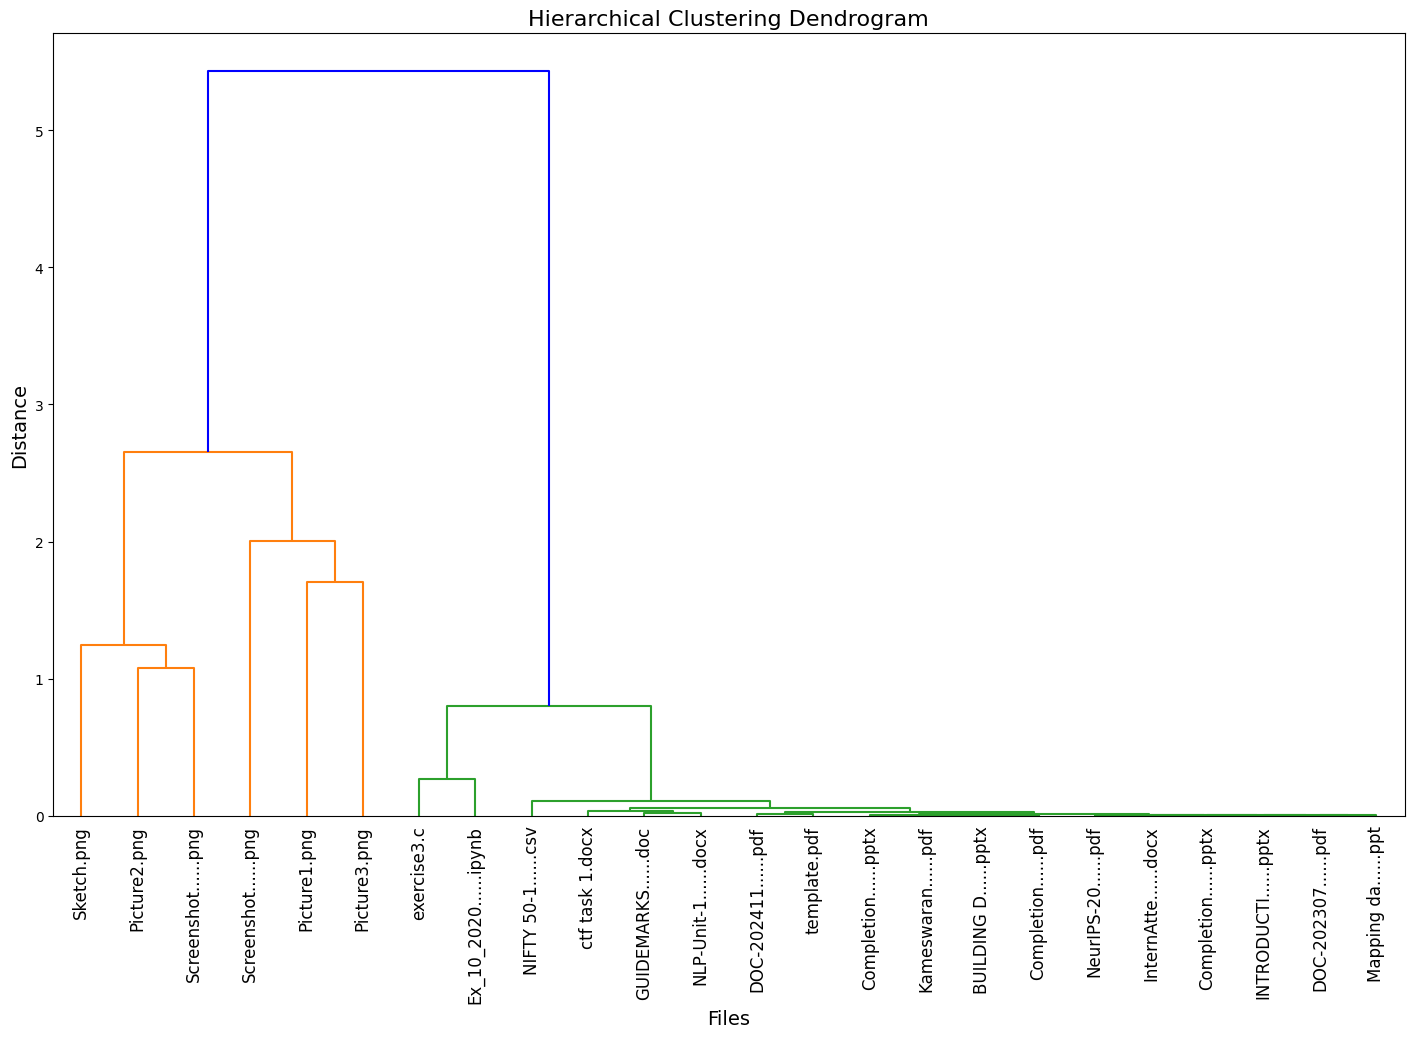

Intra-cluster distances:
Cluster 1: 61.4949
Cluster 2: 6268.5324
Cluster 3: 0.0000
Cluster 4: 0.0000
Cluster 5: 0.0000
Average inter-cluster distance: 6729.1637
Silhouette Score: 0.6294
Davies-Bouldin Index: 0.2984


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
import mimetypes
import filetype
import hashlib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image
from io import BytesIO

def detect_file_type(file_path):
    """
    Detects the file type using its MIME type.
    """
    kind = filetype.guess(file_path)
    if kind:
        return kind.mime
    else:
        mime_type, _ = mimetypes.guess_type(file_path)
        return mime_type or "unknown"

def parse_file_to_representation(file_path):
    """
    Parse a single file into an appropriate representation based on its type.
    """
    file_type = detect_file_type(file_path)
    
    if file_type.startswith("text"):
        # Text files: Use TF-IDF or hash-based representation
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            text_data = f.read()
        # Return hash-based representation (128-bit hash as a vector)
        return np.array([int(x, 16) for x in hashlib.md5(text_data.encode()).hexdigest()])

    elif file_type.startswith("image"):
        # Image files: Convert to resized grayscale for uniformity
        with open(file_path, 'rb') as f:
            image = Image.open(BytesIO(f.read()))
            image = image.convert('L')  # Grayscale
            image = image.resize((64, 64))  # Resize to fixed dimensions
        return np.array(image).flatten()  # Flatten the image array

    elif file_type.startswith("audio"):
        # Audio files: Extract spectrogram features
        return extract_audio_features(file_path)

    elif file_type.startswith("application"):
        # Binary files: Use byte frequency distribution
        with open(file_path, 'rb') as f:
            data = f.read()
        byte_counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
        return byte_counts / len(data)  # Normalize frequencies

    else:
        # Unknown files: Use file size and hash for representation
        with open(file_path, 'rb') as f:
            data = f.read()
        hash_digest = hashlib.md5(data).hexdigest()
        return np.array([int(hash_digest[i:i+2], 16) for i in range(0, 32, 2)])

def extract_audio_features(file_path):
    """
    Placeholder for audio feature extraction (e.g., spectrogram or embeddings).
    Requires libraries like librosa.
    """
    import librosa
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    return np.mean(spectrogram, axis=1)  # Example: mean of each frequency bin

def parse_files_to_features(directory_path):
    """
    Parse all files in a directory into their optimal representations.
    """
    features = []
    file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    
    for file_path in file_paths:
        try:
            representation = parse_file_to_representation(file_path)
            features.append(representation)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    return features, file_paths


def compute_jaccard_similarity(features):
    n = len(features)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            set_i, set_j = set(features[i]), set(features[j])
            intersection = len(set_i & set_j)
            union = len(set_i | set_j)
            similarity_matrix[i, j] = similarity_matrix[j, i] = intersection / union
    return similarity_matrix


def hierarchical_clustering(features):
    """
    Perform hierarchical clustering using agglomerative methods.
    """
    similarity_matrix = compute_jaccard_similarity(features)
    # Convert similarities to distances
    distance_matrix = 1 - similarity_matrix / similarity_matrix.max()
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(pairwise_distances(distance_matrix), method='average')  # Change method as needed
    return linkage_matrix


def pad_features(features, target_length=None):
    """
    Pads or truncates features to a fixed length.
    """
    if target_length is None:
        target_length = max(len(f) for f in features)  # Set target length to the longest feature vector
    
    padded_features = []
    for feature in features:
        feature = np.array(feature)
        if len(feature) < target_length:
            # Pad with zeros
            feature = np.pad(feature, (0, target_length - len(feature)), mode='constant')
        elif len(feature) > target_length:
            # Truncate to target length
            feature = feature[:target_length]
        padded_features.append(feature)
    
    return np.array(padded_features)


# Example usage
directory_path = './data'  # Replace with the path to your directory
features, file_paths = parse_files_to_features(directory_path)

# Pad the feature vectors before clustering
padded_features = pad_features(features)
linkage_matrix = hierarchical_clustering(padded_features)

print(linkage_matrix.shape)
print(len(file_paths))

# Display results
print("Files processed:")
for i, path in enumerate(file_paths):
    print(f"{i}: {path}")


def truncate_filename(filename, max_length=10):
    """
    Truncates a filename, keeping the start, '.....', and the extension.
    """
    name, ext = os.path.splitext(filename)
    if len(name) > max_length:
        return f"{name[:max_length]}.....{ext}"
    return filename

def plot_dendrogram(linkage_matrix, file_paths):
    """
    Plots a dendrogram with truncated filenames for readability, with clearer branches.
    """
    # Generate truncated labels
    truncated_labels = [truncate_filename(os.path.basename(fp)) for fp in file_paths]
    
    plt.figure(figsize=(14, 10))  # Adjust figure size for more space
    
    # Create the dendrogram
    dendrogram(
        linkage_matrix,
        labels=truncated_labels,
        leaf_rotation=90,  # Rotate x-axis labels for better spacing
        leaf_font_size=12,  # Adjust font size for labels
        color_threshold=0.5 * max(linkage_matrix[:, 2]),  # Set color threshold to separate clusters
        above_threshold_color='blue',  # Color for clusters above threshold
        orientation='top',  # Oriented top-to-bottom to improve spacing
        count_sort='ascending',  # Sort the count to avoid flattening of branches
        no_labels=False,  # Show labels to avoid confusion
        show_contracted=True,  # Show contracted branches for clarity
    )
    
    plt.tight_layout()  # Adjust layout to avoid cutting off labels
    plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
    plt.xlabel("Files", fontsize=14)
    plt.ylabel("Distance", fontsize=14)
    plt.show()


# Example usage
plot_dendrogram(linkage_matrix, file_paths)

from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist
import numpy as np

def compute_cluster_metrics(linkage_matrix, features, threshold=1.5):
    """
    Computes intra-cluster and inter-cluster distances.
    """
    # Assign clusters based on a distance threshold
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    unique_clusters = np.unique(clusters)
    
    cluster_features = {cluster: [] for cluster in unique_clusters}
    
    # Group features by cluster
    for i, cluster in enumerate(clusters):
        cluster_features[cluster].append(features[i])
    
    # Calculate intra-cluster distances
    intra_cluster_distances = {}
    cluster_centroids = {}
    
    for cluster, points in cluster_features.items():
        points_array = np.array(points)
        centroid = np.mean(points_array, axis=0)
        cluster_centroids[cluster] = centroid
        intra_dist = np.mean(cdist(points_array, [centroid], metric='euclidean'))
        intra_cluster_distances[cluster] = intra_dist
    
    # Calculate inter-cluster distances
    inter_cluster_distances = []
    centroids = np.array(list(cluster_centroids.values()))
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            dist = np.linalg.norm(centroids[i] - centroids[j])
            inter_cluster_distances.append(dist)
    
    avg_inter_cluster_distance = np.mean(inter_cluster_distances) if inter_cluster_distances else 0
    
    return intra_cluster_distances, avg_inter_cluster_distance

# Example usage
intra_cluster_distances, avg_inter_cluster_distance = compute_cluster_metrics(linkage_matrix, padded_features)

print("Intra-cluster distances:")
for cluster, dist in intra_cluster_distances.items():
    print(f"Cluster {cluster}: {dist:.4f}")

print(f"Average inter-cluster distance: {avg_inter_cluster_distance:.4f}")

from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_avg = silhouette_score(padded_features, fcluster(linkage_matrix, t=0.5, criterion='distance'))
print(f"Silhouette Score: {silhouette_avg:.4f}")


db_index = davies_bouldin_score(padded_features, fcluster(linkage_matrix, t=0.5, criterion='distance'))
print(f"Davies-Bouldin Index: {db_index:.4f}")

